### Importing necessary libraries

First we want to read the image to be compressed. For that Pillow library, popularly known as PIL, will be used. Along with that, Numpy, Matplotlib and OS will be used to store the image array, ploting the image and read image file from the operating system.

In [1]:
from PIL import Image, ImageOps                   # Image Manipulation
import numpy as np                     
import os
import matplotlib.pyplot as plt         # Visualization

Matplotlib created a temporary config/cache directory at /var/folders/w1/ddjn79r10gb30q27xq0t_fjw0000gn/T/matplotlib-co3cs8lj because the default path (/Users/ravishkumar/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


We will be writing a function to quickly check the basic featurs of the provided image. Later this function will be used to find the details of compressed image as well.

In [3]:
def img_data(imgPath,disp = True):
    
    orig_img = Image.open(imgPath)
    
    img_size_kb = os.stat(imgPath).st_size/1024
    
    ori_pixels = np.array(orig_img.getdata()).reshape(*orig_img.size, -1)
    
    img_dim = ori_pixels.shape 
    
    if disp:
        plt.imshow(orig_img)
        plt.show()
    
    data_dict = {}
    data_dict['img_size_kb'] = img_size_kb
    data_dict['img_dim'] = img_dim
    
    return data_dict

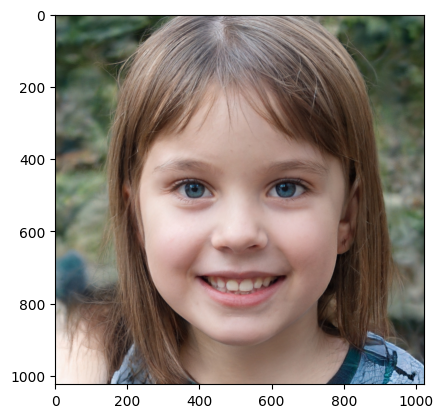

Original Image Data
Original Image size (kB) 465.8779296875
Original Image Shape (1024, 1024, 3)


In [4]:
imgPath = 'girl.jpeg';

data_dict_ori = img_data(imgPath)

print('Original Image Data')
print('Original Image size (kB)',data_dict_ori['img_size_kb'])
print('Original Image Shape',data_dict_ori['img_dim'])

So, we have an image having size 466 kB and of shape with resolution 1024x1024 and with three channels RGB.

### Writing function to avoid the repeatation of the code to find the principal component analysis for every channel.

In [5]:
from sklearn.decomposition import PCA

def pca_compose(imgPath):
    
    orig_img = Image.open(imgPath)
    # 1. Read the image
    orig_img = Image.open(imgPath)
    
    # 2. Convert the reading into a 2D numpy array
    img = np.array(orig_img.getdata())
    
    # 3. Reshape 2D to 3D array 
    # The asterisk (*) operator helps in unpacking the sequence/collection as positional arguments. 
    # So, instead of using indices of elements separately, we can use * and perform action on it.
    # print(orig_img.size) = (1024, 1024) --> print(*orig_img.size) = 1024 1024
    img = img.reshape(*orig_img.size, -1)
    
    # Seperate channels from image and use PCA on each channel
    pca_channel = {}
    img_t = np.transpose(img) # transposing the image 
    
    for i in range(img.shape[-1]):    # For each RGB channel compute the PCA
        
        per_channel = img_t[i] # It will be in a shape (1,1024,1024)
        
        # Converting (1, 1024, 1024) to (1024, 1024)
        channel = img_t[i].reshape(*img.shape[:-1])  # obtain channel
        
        pca = PCA(random_state = 42)                #initialize PCA
        
        fit_pca = pca.fit_transform(channel)        #fit PCA
        
        pca_channel[i] = (pca,fit_pca)  #save PCA models for each channel
        
    return pca_channel

In [6]:
pca_channel = pca_compose(imgPath)

### Function to tell the percentage of explained variance by 'n' number of components

In [7]:
def explained_var_n(pca_channel, n_components):
    
    var_exp_channel = []; var_exp=0
    
    for channel in pca_channel:
        
        pca,_ = pca_channel[channel]
        
        var_exp_channel.append(np.cumsum(pca.explained_variance_ratio_))
        
        var_exp += var_exp_channel[channel][n_components]
        
    var_exp = var_exp/len(pca_channel)
    
    return var_exp

### Let's choose a random number of component to retain.

As we know, our image is of the shape 1024*1024 so maximum number of components can be 0 to 1023. Please play with this number to see how much difference will be coming.

In [10]:
var_exp = explained_var_n(pca_channel, 1023)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  99.99999999999997 %


### Function to plot the individual variance of every principal component. As there are 1024 components, we will be plotting till 20th principal companents


In [11]:
def variance_added_pc(pca_channel):
    
    var_exp_channel = [];var_exp=0;
    
    for channel in pca_channel:
        pca,_ = pca_channel[channel]
        var_exp_channel.append(pca.explained_variance_ratio_)
        
    var_exp = (var_exp_channel[0]+var_exp_channel[1]+var_exp_channel[2])/3
    
    x = list(var_exp);y = list(range(1,1+len(x)));y = list(range(1,21))
    
    plt.yticks(np.arange(0, max(x)+0.05,0.05))
    plt.xticks(np.arange(min(y), max(y)+1,1))
    plt.title("Individual Variance for each Principal Component")
    plt.ylabel('Variance')
    plt.xlabel('Principal Component');
    plt.bar(y,x[:20],color = 'black')
    #plt.grid(True)
    plt.show()

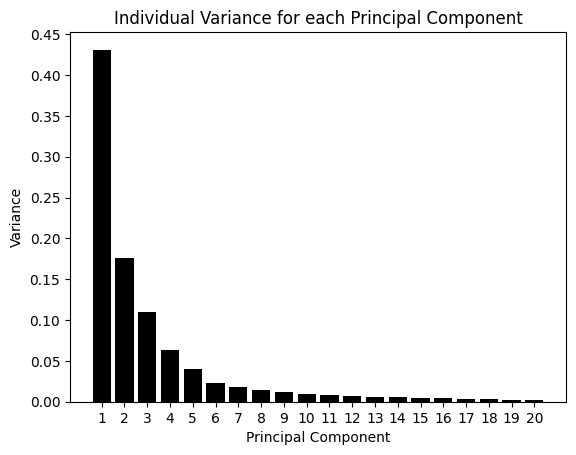

In [12]:
variance_added_pc(pca_channel)

### Function to plot the explained variance/information w.r.t the number of components

Now the main concern is, how many components we should retain to maximize the reduction in size but not loosing too much information from the image.

In [13]:
def plot_variance_pc(pca_channel):
    
    pca,fit_pca = pca_channel[0]
    
    exp_var = {}
    
    for i in range(len(pca.components_)):
        var_exp = explained_var_n(pca_channel,i)
        exp_var[i+1] = var_exp
    
    lists = sorted(exp_var.items()) # sorted by key, return a list of tuples
    
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    pt90 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.9)
    pt95 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.95)
    
    plt.plot(x, y)
    plt.vlines(x=x[pt90], ymin=0, ymax=y[pt90], colors='green',  ls=':', lw=2, label=str('90% Variance Explained : n = '+str(x[pt90])))
    plt.vlines(x=x[pt95], ymin=0, ymax=y[pt95], colors='red', ls=':', lw=2, label=str('95% Variance Explained : n = '+str(x[pt95])))
    
    plt.xticks(np.arange(min(x)-1, max(x)-1,100))
    plt.yticks(np.arange(0, max(y),0.1))
    
    plt.legend(loc="lower right")
    plt.title("Variance vs Principal Components")
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Explained")
    plt.grid(True)
    plt.show()

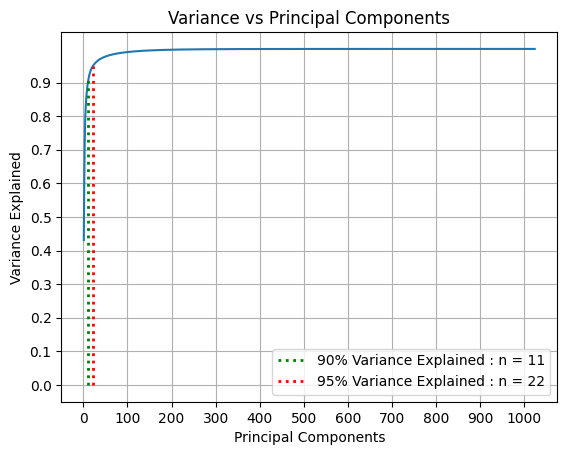

In [14]:
plot_variance_pc(pca_channel)

### So even if we select 50 components, the information retention will be huge. So let's go with this number


In [15]:
n_components = 50

var_exp = explained_var_n(pca_channel, n_components)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  97.778657925892 %


So, with 50 PCs, we are able to retain 97.77% information from the original image.

### Function to select the desired number of components

In [16]:
def pca_transform(pca_channel, n_components):
    
    temp_res = []
    
    # Looping over all the channels we created from pca_compose function
    
    for channel in range(len(pca_channel)):
        
        pca, fit_pca = pca_channel[channel]
        
        # Selecting image pixels across first n components
        pca_pixel = fit_pca[:, :n_components]
        
        # First n-components
        pca_comp = pca.components_[:n_components, :]
        
        # Projecting the selected pixels along the desired n-components (De-standardization)
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca.mean_
        
        # Stacking channels corresponding to Red Green and Blue
        temp_res.append(compressed_pixel)
            
    # transforming (channel, width, height) to (height, width, channel)
    compressed_image = np.transpose(temp_res)
    
    # Forming the compressed image
    compressed_image = np.array(compressed_image,dtype=np.uint8)
    
    return compressed_image

### Let's visualize the compressed image by first retaining the first 50 components

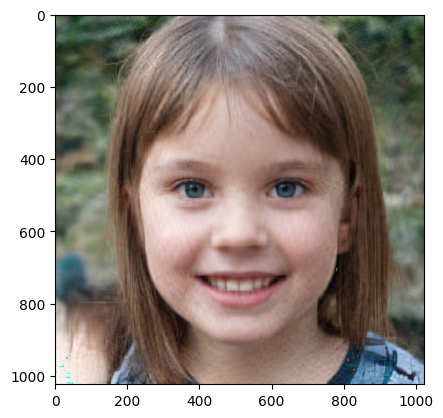

In [18]:
compressed_image = pca_transform(pca_channel,n_components=n_components)

# Display

plt.imshow(compressed_image)
plt.show()

Image.fromarray(compressed_image).save("compressed_img.jpeg")

# This will save the compressed image

### We will use the earlier defined function to find the basic details about this image

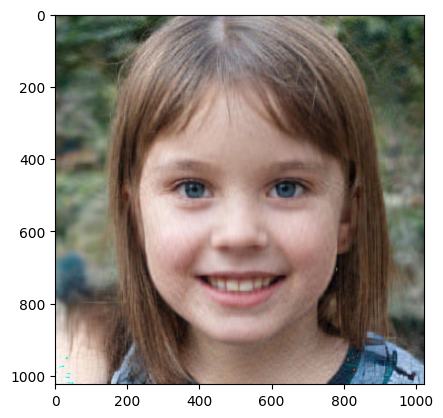

Compressed Image Data
Compressed Image size (kB) 86.8994140625
Compression Percentage 81.3471708950046 %
Compressed Image Shape (1024, 1024, 3)


In [19]:
imgPath = 'compressed_img.jpeg';

data_dict_comp = img_data(imgPath)

print('Compressed Image Data')
print('Compressed Image size (kB)',data_dict_comp['img_size_kb'])
print('Compression Percentage', 100 - (data_dict_comp['img_size_kb']/data_dict_ori['img_size_kb'])*100,'%')
print('Compressed Image Shape',data_dict_comp['img_dim'])

So, we reduced the image size from 466 kBs to 86.9 kBs and the reduction is huge without changiung the dimensions of the image.

### Function to plot the size of the compressed image w.r.t the number of components


In [20]:
def plot_size_pc(pca_channel):
    
    pca,fit_pca = pca_channel[0]
    kB = {}
    
    for i in range(len(pca.components_)):
        
        compressed_image = pca_transform(pca_channel,i)
        pil_img = Image.fromarray(compressed_image).save("loop_compressed_img.jpeg")
        size = os.stat('loop_compressed_img.jpeg').st_size/1024
        kB[i+1] = size
    
    lists = sorted(kB.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    yy = []
    for i in range(len(y)):
        yy.append((max(y)-y[i])/max(y))
    
    yy = tuple(yy)
    pt20 = next(xx[0] for xx in enumerate(yy) if xx[1] < 0.2)
    pt50 = next(xx[0] for xx in enumerate(yy) if xx[1] < 0.5)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.plot(x, y)
    ax1.set_ylabel('kB', color='b')
    ax1.set_xlabel("Principal Components")
    ax2 = ax1.twinx()
    ax1.set_title("Size vs Principal Components")
    ax2.plot(x, yy, 'r-')
    ax2.set_ylabel('% reduced', color='r')
    
    ax1.grid(True)
    ax2.vlines(x=x[pt20], ymin=0, ymax=yy[pt20], colors='green', ls=':', lw=2, label=str('20% Reduction : n = '+str(x[pt20])))
    ax2.vlines(x=x[pt50], ymin=0, ymax=yy[pt50], colors='orange', ls=':', lw=2, label=str('50% Reduction : n = '+str(x[pt50])))
    ax2.legend()

### Calling above function will take time as it willl be fitting the PCA model on multiple number of channels. So be patient.

In [ ]:
plot_size_pc(pca_channel)